In [ ]:
!pip install -q transformers datasets torch torchvision albumentations roboflow pytorch_lightning

# init

In [44]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import torch.nn as nn
import pytorch_lightning as pl
import torchvision
import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import torchvision.transforms.functional as TF
import torch.optim as optim
from tqdm import tqdm
import time

BASE_PATH = "/home/ubuntu/work/pdfBLines/datasetCrop"
# BASE_PATH = "/home/ubuntu/work/carvana/dataset/"
CHECKPOINT_PATH = "/home/ubuntu/work/pdfBLines/ckpt"


# Hyperparameters etc.
LEARNING_RATE = 1e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# print("DEVICE", DEVICE)
BATCH_SIZE = 32
NUM_EPOCHS = 100
NUM_WORKERS = 2
IMAGE_HEIGHT = 224 
IMAGE_WIDTH = 224  
PIN_MEMORY = True
LOAD_MODEL = False



# Dataset

In [27]:

class BLinesDataset(Dataset):
    def __init__(self, root_dir, transform=None):     
        self.root_dir = root_dir
        self.transform = transform
        
        self.images = os.listdir(self.root_dir)    
        self.images = list(filter(lambda x: "jpg" in x, self.images))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.images[index])
        mask_path = os.path.join(self.root_dir, self.images[index].replace(".jpg", "_mask.png"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask > 0] = 1.0
        
        if self.transform is not None:
            augmentations = self.transform(image=image,mask=mask)
            image1 = augmentations['image']
            # assert image1.shape == image.shape, f"{ image1.shape},  {image.shape}"
            mask1 = augmentations['mask']
            
        return image1,mask1
        

In [28]:

class CarvanaDataset(Dataset):
    def __init__(self, root_dir, transform=None):     
        self.root_dir = root_dir
        self.transform = transform
        
        self.images = os.listdir(self.root_dir)    
        self.images = list(filter(lambda x: "jpg" in x, self.images))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.images[index])
        mask_path = os.path.join(self.root_dir, self.images[index].replace(".jpg", "_mask.gif"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255] = 1.0
        
        if self.transform is not None:
            augmentations = self.transform(image=image,mask=mask)
            image1 = augmentations['image']
            # assert image1.shape == image.shape, f"{ image1.shape},  {image.shape}"
            mask1 = augmentations['mask']
            
        return image1,mask1
        

In [29]:
train_transform = A.Compose(
    [
        A. Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        # A. Rotate(limit=35, p=1.0),
        # A.HorizontalFlip(p=0.5),
        # A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)
val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)


In [30]:
# UnetDataset = CarvanaDataset
UnetDataset = BLinesDataset
train_ds = UnetDataset(
    root_dir=os.path.join(BASE_PATH,"train"),
    transform=train_transform,
)

train_loaders = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
)

val_ds = UnetDataset(
    root_dir=os.path.join(BASE_PATH,"valid"),

    transform=val_transform,
)
val_loaders = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
)


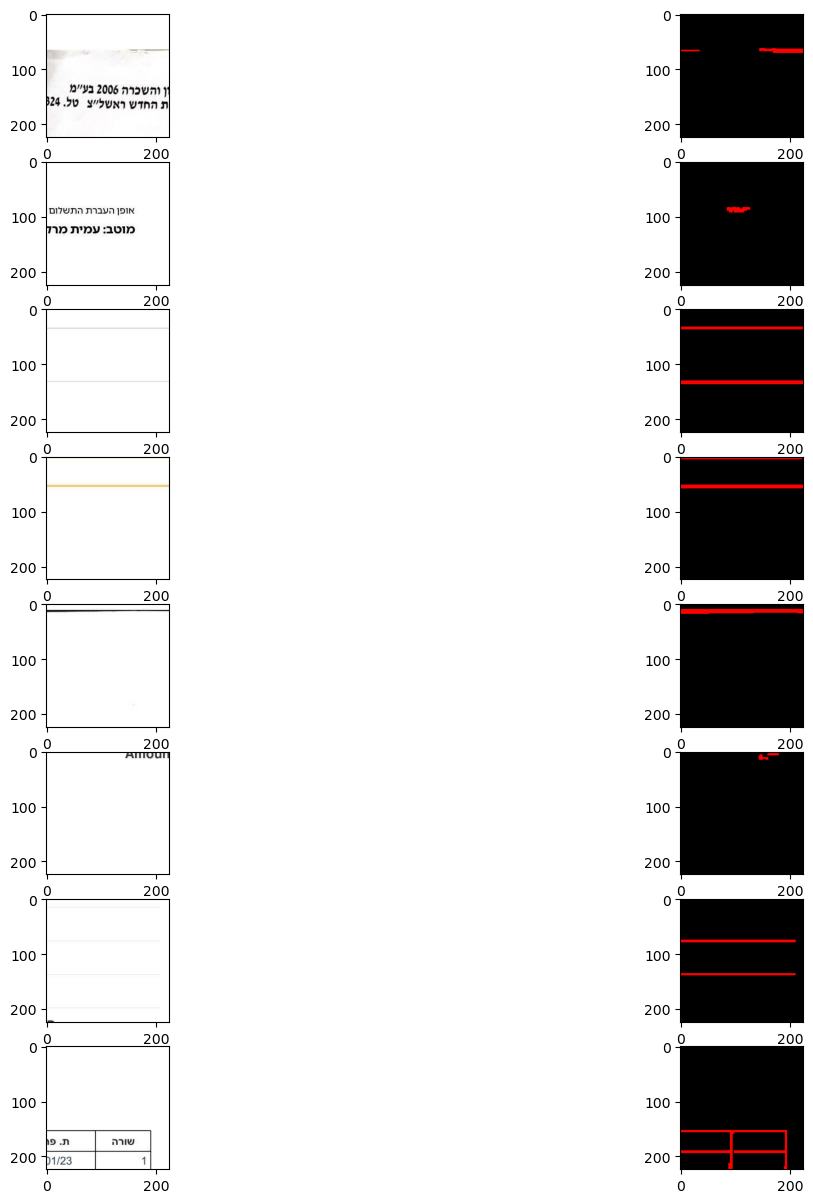

In [31]:
color_map = {
    0:(0,0,0),
    1:(255,0,0),
}

def prediction_to_vis(prediction):
    vis_shape = prediction.shape + (3,)
    vis = np.zeros(vis_shape)
    for i,c in color_map.items():
        vis[prediction == i] = color_map[i]
    return Image.fromarray(vis.astype(np.uint8))

for batch in train_loaders:
    images, masks = batch
    break

n_plots = 8
f, axarr = plt.subplots(n_plots,2)
f.set_figheight(15)
f.set_figwidth(15)

for i in range(n_plots):
    image =images[i,:,:].permute(1, 2, 0)
    axarr[i,0].imshow(image)
    axarr[i,1].imshow(prediction_to_vis(masks[i,:,:]))

# Unet model

In [32]:

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            # kernel, stride, padding - same convolution
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            # kernel, stride, padding - same convolution
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class UNET(nn.Module):
    def __init__(self,
                 in_channels=3, out_channels=1,
                 features=[64, 128, 256, 512]
                 ) -> None:
        super(UNET, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)


def test():
    x = torch.randn((3, 1, 161, 161))
    model = UNET(in_channels=1, out_channels=1)
    pred = model(x)
    print(pred.shape)
    print(x.shape)
    assert pred.shape == x.shape


test()

torch.Size([3, 1, 161, 161])
torch.Size([3, 1, 161, 161])


# Utils

In [50]:

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint",filename)
    torch.save(state, filename)

def check_accuracy(loader, model, device="cuda"):
    print("Checking accuracy")
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for idx, (x, y) in enumerate(loader):
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            
            acc = (preds == y).sum()
            numElem = torch.numel(preds)
            # print(idx, acc/numElem)
            
            num_correct += acc
            num_pixels += numElem
            dice_score += (2*(preds*y).sum())/(
                (preds+y).sum() + 1e-8
            )

        print(
            f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
        )

        dice = dice_score/len(loader)
        print(f"Dice score: {dice}")

        model.train()
    return dice


def save_predictions_as_imgs(
    loader, model, folder="saved_images/", device="cuda"
):
    print("Saving predictions")
    start = time.time()
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds, os.path.join(folder,f"pred_{idx}.png")
        )
        torchvision.utils.save_image(y.unsqueeze(1), 
                                    os.path.join(folder,f"correct_{idx}.png")
                                     )
    print(f"Saved predictions in {time.time()-start:.2f} seconds")
    model.train()


# Train

In [34]:
model = UNET(in_channels=3, out_channels=1).to(DEVICE)

In [39]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)
    for batch_idx, (data, targets) in enumerate(loop):
    # for i in range(10):
        # data, targets = next(iter(loader))
        
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        # print("loss", loss.item())

        # update tqdm
        loop.set_postfix(loss=loss.item())

In [40]:
# pos_weight = torch.ones([224]).to(DEVICE)
# loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
loss_fn = nn.BCEWithLogitsLoss()
# loss_fn = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

scaler = torch.cuda.amp.grad_scaler.GradScaler()
for epoch in range(NUM_EPOCHS):
    print("epoch", epoch)
    train_fn(train_loaders, model, optimizer, loss_fn, scaler)





    # print some example to folder
    if epoch % 10 == 0:
        # save model
        check_point = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        dice_score =check_accuracy(val_loaders, model, device=DEVICE)        
        save_checkpoint(check_point, os.path.join(CHECKPOINT_PATH,f"blines_dice{dice_score}.pth.tar"))        
        save_predictions_as_imgs(
            val_loaders, model, folder="save_images/", device=DEVICE
        )


epoch 0


100%|██████████| 294/294 [00:42<00:00,  6.95it/s, loss=0.258]

Saving predictions


Saved predictions in 3.40 seconds
epoch 1


100%|██████████| 294/294 [00:42<00:00,  6.92it/s, loss=0.237]


epoch 2


100%|██████████| 294/294 [00:42<00:00,  6.91it/s, loss=0.222]


epoch 3


100%|██████████| 294/294 [00:42<00:00,  6.90it/s, loss=0.216]


epoch 4


100%|██████████| 294/294 [00:42<00:00,  6.90it/s, loss=0.198]


epoch 5


100%|██████████| 294/294 [00:42<00:00,  6.89it/s, loss=0.197]


epoch 6


100%|██████████| 294/294 [00:42<00:00,  6.89it/s, loss=0.188]


epoch 7


100%|██████████| 294/294 [00:42<00:00,  6.88it/s, loss=0.16] 


epoch 8


100%|██████████| 294/294 [00:42<00:00,  6.89it/s, loss=0.157]


epoch 9


100%|██████████| 294/294 [00:42<00:00,  6.89it/s, loss=0.146]


epoch 10


100%|██████████| 294/294 [00:42<00:00,  6.88it/s, loss=0.136]

Saving predictions


Saved predictions in 3.45 seconds
epoch 11


100%|██████████| 294/294 [00:42<00:00,  6.89it/s, loss=0.13] 


epoch 12


100%|██████████| 294/294 [00:42<00:00,  6.89it/s, loss=0.124]


epoch 13


100%|██████████| 294/294 [00:42<00:00,  6.86it/s, loss=0.109]


epoch 14


100%|██████████| 294/294 [00:42<00:00,  6.88it/s, loss=0.105]


epoch 15


100%|██████████| 294/294 [00:42<00:00,  6.89it/s, loss=0.101] 


epoch 16


100%|██████████| 294/294 [00:42<00:00,  6.88it/s, loss=0.0956]


epoch 17


100%|██████████| 294/294 [00:42<00:00,  6.88it/s, loss=0.0893]


epoch 18


100%|██████████| 294/294 [00:42<00:00,  6.88it/s, loss=0.0853]


epoch 19


100%|██████████| 294/294 [00:42<00:00,  6.87it/s, loss=0.076] 


epoch 20


100%|██████████| 294/294 [00:42<00:00,  6.87it/s, loss=0.0752]

Saving predictions


Saved predictions in 3.49 seconds
epoch 21


100%|██████████| 294/294 [00:42<00:00,  6.87it/s, loss=0.0686]


epoch 22


100%|██████████| 294/294 [00:42<00:00,  6.87it/s, loss=0.0662]


epoch 23


100%|██████████| 294/294 [00:42<00:00,  6.87it/s, loss=0.0587]


epoch 24


100%|██████████| 294/294 [00:42<00:00,  6.87it/s, loss=0.0578]


epoch 25


100%|██████████| 294/294 [00:42<00:00,  6.88it/s, loss=0.0593]


epoch 26


100%|██████████| 294/294 [00:42<00:00,  6.86it/s, loss=0.0541]


epoch 27


100%|██████████| 294/294 [00:42<00:00,  6.86it/s, loss=0.048] 


epoch 28


100%|██████████| 294/294 [00:42<00:00,  6.85it/s, loss=0.0482]


epoch 29


100%|██████████| 294/294 [00:42<00:00,  6.86it/s, loss=0.0414]


epoch 30


100%|██████████| 294/294 [00:43<00:00,  6.80it/s, loss=0.0386]

Saving predictions


Saved predictions in 3.77 seconds
epoch 31


 96%|█████████▌| 282/294 [00:41<00:01,  6.87it/s, loss=0.0373]


KeyboardInterrupt: 

In [52]:
dice_score =check_accuracy(val_loaders, model, device=DEVICE)        
save_checkpoint(check_point, os.path.join(CHECKPOINT_PATH,f"blines_dice{dice_score:.2F}.pth.tar"))        


Checking accuracy
Got 8275442/8329216 with acc 99.35
Dice score: 0.9266595840454102
=> Saving checkpoint /home/ubuntu/work/pdfBLines/ckpt/blines_dice0.93.pth.tar


 # view results

In [ ]:
loader = val_loaders
folder="./save_images"
device=DEVICE

try:
    os.mkdir(folder)
except FileExistsError:
    print("Directory ",folder," already exists")


In [ ]:
for idx, (x, y) in enumerate(val_loaders):
    x = x.to(device=device)
    with torch.no_grad():
        preds = torch.sigmoid(model(x))
        preds = (preds > 0.5).float()
    torchvision.utils.save_image(preds, os.path.join(folder,f"pred_{idx}.png"))
    torchvision.utils.save_image(y.unsqueeze(1), os.path.join(folder,f"correct_{idx}.png"))

In [ ]:

for idx, (pixel_values,masks) in enumerate(val_loaders):
    print(idx, pixel_values.shape)
    preds = torch.sigmoid(model(pixel_values))
    predicted_mask = (preds > 0.5).float()
    masks = masks.cpu().numpy()
    break # only one batch


0 torch.Size([8, 3, 160, 240])


In [ ]:
print("predicted_mask.shape",predicted_mask.shape)
print("masks.shape",masks.shape)

predicted_mask.shape torch.Size([8, 1, 160, 240])
masks.shape (8, 160, 240)


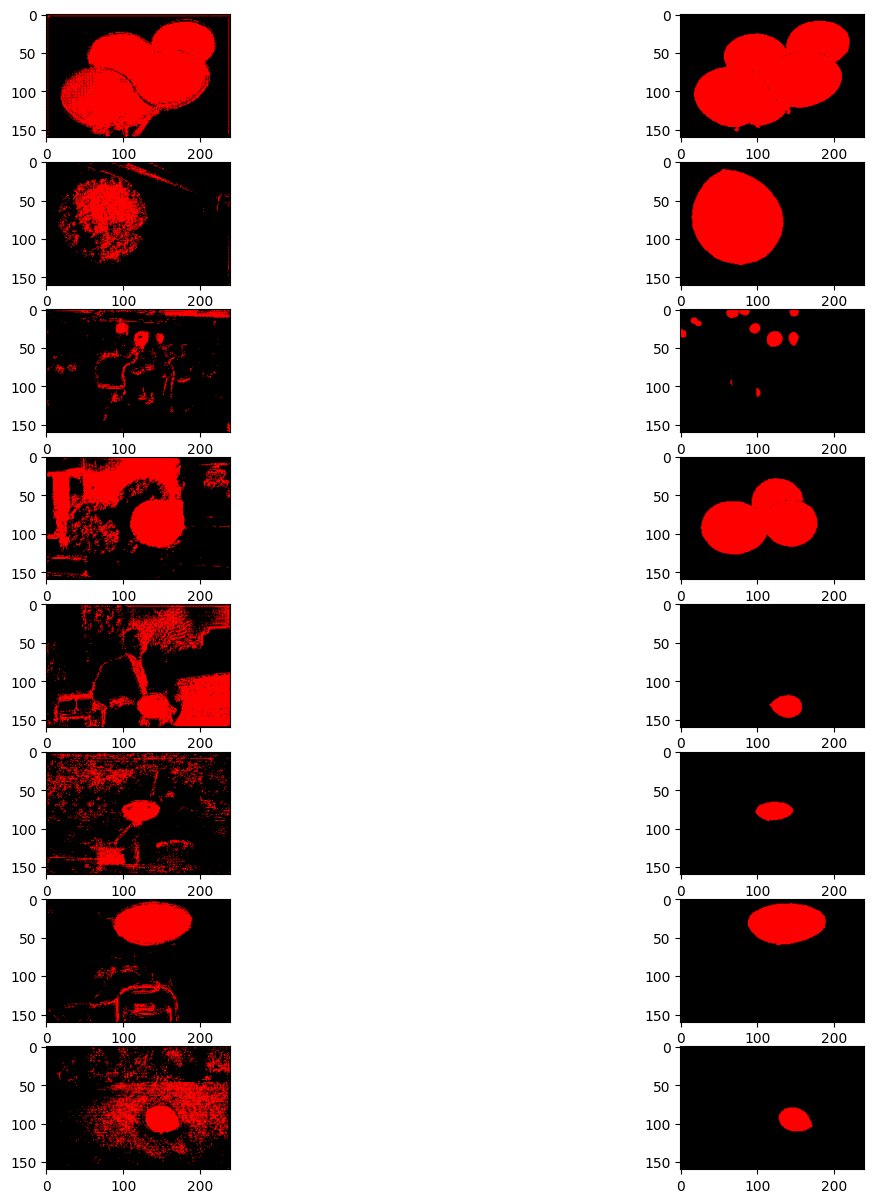

In [ ]:
color_map = {
    0:(0,0,0),
    1:(255,0,0),
}

def prediction_to_vis(prediction):
    vis_shape = prediction.shape + (3,)
    vis = np.zeros(vis_shape)
    for i,c in color_map.items():
        vis[prediction == i] = color_map[i]
    return Image.fromarray(vis.astype(np.uint8).squeeze())
n_plots = 8
from matplotlib import pyplot as plt
f, axarr = plt.subplots(n_plots,2)
f.set_figheight(15)
f.set_figwidth(15)
for i in range(n_plots):
    axarr[i,0].imshow(prediction_to_vis(predicted_mask[i,:,:]))
    axarr[i,1].imshow(prediction_to_vis(masks[i,:,:]))

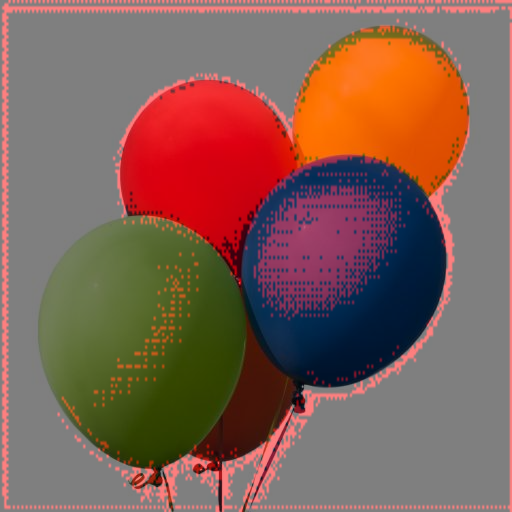

In [ ]:
#Predict on a test image and overlay the mask on the original image
test_idx = 0
input_image_file = os.path.join(val_ds.root_dir,val_ds.images[test_idx])
input_image = Image.open(input_image_file)
test_batch = val_ds[test_idx]
images, masks = test_batch
images = torch.unsqueeze(images, 0)
masks = torch.unsqueeze(masks, 0)
outputs = model(images)
preds = torch.sigmoid(outputs)
predicted_mask = (preds > 0.5).float()


mask = prediction_to_vis(predicted_mask[test_idx,:,:])
mask = mask.resize(input_image.size)
mask = mask.convert("RGBA")
input_image = input_image.convert("RGBA")
overlay_img = Image.blend(input_image, mask, 0.5)
overlay_img